# Simple MLflow example
Simple example that demonstrates use of MLflow by training a Pytorch model using MNIST-dataset.

## MLflow basics
- Runs: A run is an execution of a data science code. It is a primary unit of logging in MLflow Tracking. Each run records parameters, metrics, and artifacts.
- Experiments: An experiment is a collection of runs. It is used to organize and compare different runs. Typically, there is one experiment for each ML project or type of model.
- Artifacts: These are output files from ML runs, such as models, data files, plots, or other binary files. There are various types of artifacts, including but not limited to:
    - Model artifacts: Serialized models.
    - Data artifacts: Datasets, data samples.
    - Visualization artifacts: Plots, charts, figures.

## Usage
1. Open a terminal session, activate virtual environment and start MLflow tracking server:
```sh
    mlflow ui \
        --backend-store-uri ./my-runs \
        --registry-store-uri ./my-runs \
        --artifacts-destination ./my-artifacts
```

2. Open a browser tab in http://localhost:5000.

3. While keeping the browser tab open, run this notebook and observe the results.

## Train a Pytorch model using MNIST-dataset

In [1]:
import mlflow
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

mlflow.set_experiment('mnist_pytorch_experiment')

# Foobar

In [3]:
# Define a simple neural network for MNIST
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
# Prepare MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Dummy markdown cell

In [5]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

In [6]:
# New dummy cell
assert 1+1 == 2

print(1+1)


2


In [ ]:
# Start an MLflow run
with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_param("learning_rate", 0.003)
    mlflow.log_param("momentum", 0.003)

    # Train the model
    epochs = 10
    for e in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Log the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        mlflow.log_metric("average_train_loss", average_train_loss, step=e)

        # Evaluate on the test dataset
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)
                loss = criterion(output, labels)
                test_loss += loss.item()

        # Log the average test loss for the epoch
        average_test_loss = test_loss / len(test_loader)
        mlflow.log_metric("average_test_loss", average_test_loss, step=e)

    # Log the model
    mlflow.pytorch.log_model(model, "mnist_model")

    # Register the model
    model_uri = f"runs:/{run.info.run_id}/mnist_model"
    model_details = mlflow.register_model(model_uri=model_uri, name="MNISTModel")


## Load saved model and predict class for single MNIST image
Load saved model and predict class for a single MNIST image.

In [12]:
loaded_model = mlflow.pytorch.load_model(model_uri="models:/MNISTModel/2")
print(loaded_model)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [13]:
def predict_and_visualize(model, dataset, index):
    """
    Function to predict the digit of a given image in a dataset and visualize the image.
    
    Args:
        model: Trained PyTorch model.
        dataset: PyTorch dataset containing images.
        index: Index of the image in the dataset.
    """
    model.eval()
    img, true_label = dataset[index]
    
    # Add a batch dimension and send the image to the same device as the model
    img = img.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)
    model = model.to(device)
    
    # Make a prediction
    with torch.no_grad():
        logits = model(img)
        predicted = torch.argmax(logits, dim=1)  # Get the index of the max log-probability
    
    # Remove batch dimension, move to cpu and convert to numpy array
    img = img.squeeze().cpu().numpy()
    
    # Visualize the image and the prediction
    plt.imshow(img, cmap='Greys_r')
    plt.title(f'Predicted Digit: {predicted.item()}, True Label: {true_label}')
    plt.show()

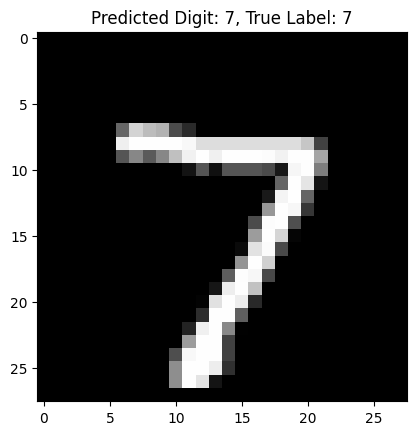

In [14]:
predict_and_visualize(loaded_model, test_dataset, index=0)